<a class="anchor" id="toc-go-back"></a>
# Assignment 1: Renewable energy trading in day-ahead and balancing markets

### Table of Contents
* [1. Constructing the dataset](#dataset)
* [2. Initial data analyses](#data-analysis)
* [3. Formulating the optimization problem](#optimization)
* [4. Building the linear regression model](#linear-regression)
    * [4.1. Closed-form solution](#linear-regression-closed-form)
    * [4.2. Gradient descent solution](#linear-regression-gradient-descent)
* [5. Investigating the role of the regularization parameter](#regularization-investigation)

In [1]:
import json
import zipfile
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Set the path to the data directory and the data save directory
DATA_DIR = Path('../../../data/assignment1')
PROCESSED_DIR = Path(r'../../../data/assignment1/processed')

<a class="anchor" id="dataset"></a>
## 1. Constructing the dataset
[_Go to Table of Contents_](#toc-go-back)

Before being able to construct the dataset and combining the various sources of information, an investigation of the file contents was carried out. Though most sources of information were handed out in more or less readable formats (i.e. `.cvs` or `.xlsx`) the [DMI ClimateData extractions](https://confluence.govcloud.dk/display/FDAPI/Climate+Data) is on a nested `json`-format. A quick overview of available weather attributes and municipalities contained in a sample file is shown below.

In [2]:
# zip file handler  
zip_ = zipfile.ZipFile(DATA_DIR / 'raw/Climate data_2021.zip')
f = zip_.open('2021-01-01.txt', 'r')

# Load a single file for examining the content of a ClimateData file
information_list = []
for line in f:
    information_list.append(json.loads(line))

# Extract and print all unique weather attributes and municipalities from the file
weather_attributes = pd.Series([information['properties']['parameterId'] for information in information_list]).unique()
municipalities = pd.Series([information['properties']['municipalityName'] for information in information_list]).unique()
print(f"Unique weather attributes: \n{weather_attributes}\n\nUnique municipalities: \n{municipalities}")

Unique weather attributes: 
['no_ice_days' 'temp_grass' 'leaf_moisture' 'mean_temp' 'mean_wind_speed'
 'max_temp_w_date' 'mean_cloud_cover' 'temp_soil_30' 'no_summer_days'
 'temp_soil_10' 'mean_daily_max_temp' 'no_lightning_strikes'
 'max_wind_speed_10min' 'bright_sunshine' 'no_tropical_nights'
 'no_cold_days' 'no_days_acc_precip_1' 'min_temp' 'drought_index'
 'mean_radiation' 'no_days_acc_precip_01' 'acc_heating_degree_days_17'
 'max_wind_speed_3sec' 'vapour_pressure_deficit_mean'
 'pot_evaporation_makkink' 'mean_pressure' 'mean_daily_min_temp'
 'mean_relative_hum' 'acc_precip' 'mean_wind_dir' 'no_days_acc_precip_10'
 'no_frost_days' 'max_precip_30m' 'snow_depth']

Unique municipalities: 
['Furesø' 'Struer' 'Egedal' 'Faxe' 'Fredericia' 'Frederikssund' 'Hvidovre'
 'Lemvig' 'Kalundborg' 'Vesthimmerlands' 'Lejre' 'Haderslev' 'Syddjurs'
 'Thisted' 'Allerød' 'Odense' 'Solrød' 'Svendborg' 'Hørsholm'
 'Lyngby-Taarbæk' 'Gribskov' 'Ikast-Brande' 'Vordingborg' 'Stevns' 'Samsø'
 'Sønderborg' 'Ro

After having considered the dataformat of the various sources of information, the `DataProcessor`-class was built with the purpose of capturing all relevant loading, initial data handling and combination of data sources in a single object. An in-depth description of the underlying ideas and considerations that were taken into account in order to combine the data sources is provided in the official handed-in report. 

Feel free to check out the `DataProcessor`-class in the `src.assigment1.data.make_dataset.py`-file.

In [4]:
from src.assignment1.data.make_dataset import DataProcessor

In the following cell, the processing is carried out. As the problem formulation specified that the task is to predict power production for a wind farm located in Roskilde, we restrict the weather data to only contain information from the municipality of Roskilde. Furthermore, an explicit choice of querying prices from DK1 and DK2 is made, yet, a file containing information from all price areas will also be available.

In [6]:
# Define the dataset loading object
processor = DataProcessor(DATA_DIR=DATA_DIR, SAVE_DIR=PROCESSED_DIR)

# Run the data loading pipeline
processor.combine_and_save_data_sources(weather_municipality='Roskilde', priceareas=['DK1', 'DK2'])

<a class="anchor" id="data-analysis"></a>
## 2. Initial data analyses
[_Go to Table of Contents_](#toc-go-back)

Now, loading the files should be rather easy. Considering the two files for DK1 and DK2 a status check to see if they match is done below.

In [3]:
# Load DK1 and DK2 datasets
DK1_dataset = pd.read_csv(PROCESSED_DIR / 'DK1.csv', index_col=0, parse_dates=['StartTimeUTC', 'EndTimeUTC'])
DK2_dataset = pd.read_csv(PROCESSED_DIR / 'DK2.csv', index_col=0, parse_dates=['StartTimeUTC', 'EndTimeUTC'])

# Print the size of the datasets
print(f"DK1 dataset size: {DK1_dataset.shape}")
print(f"DK2 dataset size: {DK2_dataset.shape}")

# Check if missing data occurs
print(f"\nNaN values occuring in DK1 dataset? {DK1_dataset.isna().any().any()}")
print(f"NaN values occuring in DK2 dataset? {DK2_dataset.isna().any().any()}")

# Verify identical columns of the datasets
print(f"\nDK1 and DK2 have the same columns? {np.array_equal(np.array(DK1_dataset.columns), np.array(DK2_dataset.columns))}")

# Print available columns
print(f"{np.array(DK1_dataset.columns).reshape(-1, 1)}")

DK1 dataset size: (17517, 12)
DK2 dataset size: (17517, 12)

NaN values occuring in DK1 dataset? False
NaN values occuring in DK2 dataset? False

DK1 and DK2 have the same columns? True
[['StartTimeUTC']
 ['EndTimeUTC']
 ['PriceArea']
 ['Actual']
 ['SpotPriceDKK']
 ['SpotPriceEUR']
 ['BalancingMarketPrice_DownReg']
 ['BalancingMarketPrice_UpReg']
 ['max_wind_speed_10min']
 ['max_wind_speed_3sec']
 ['mean_wind_dir']
 ['mean_wind_speed']]


As an initial investigation, the interest is restricted to DK2 since this is were the wind power farm is located.

In [4]:
# TODO: some initial general data analyses (e.g. correlation structure, etc.)

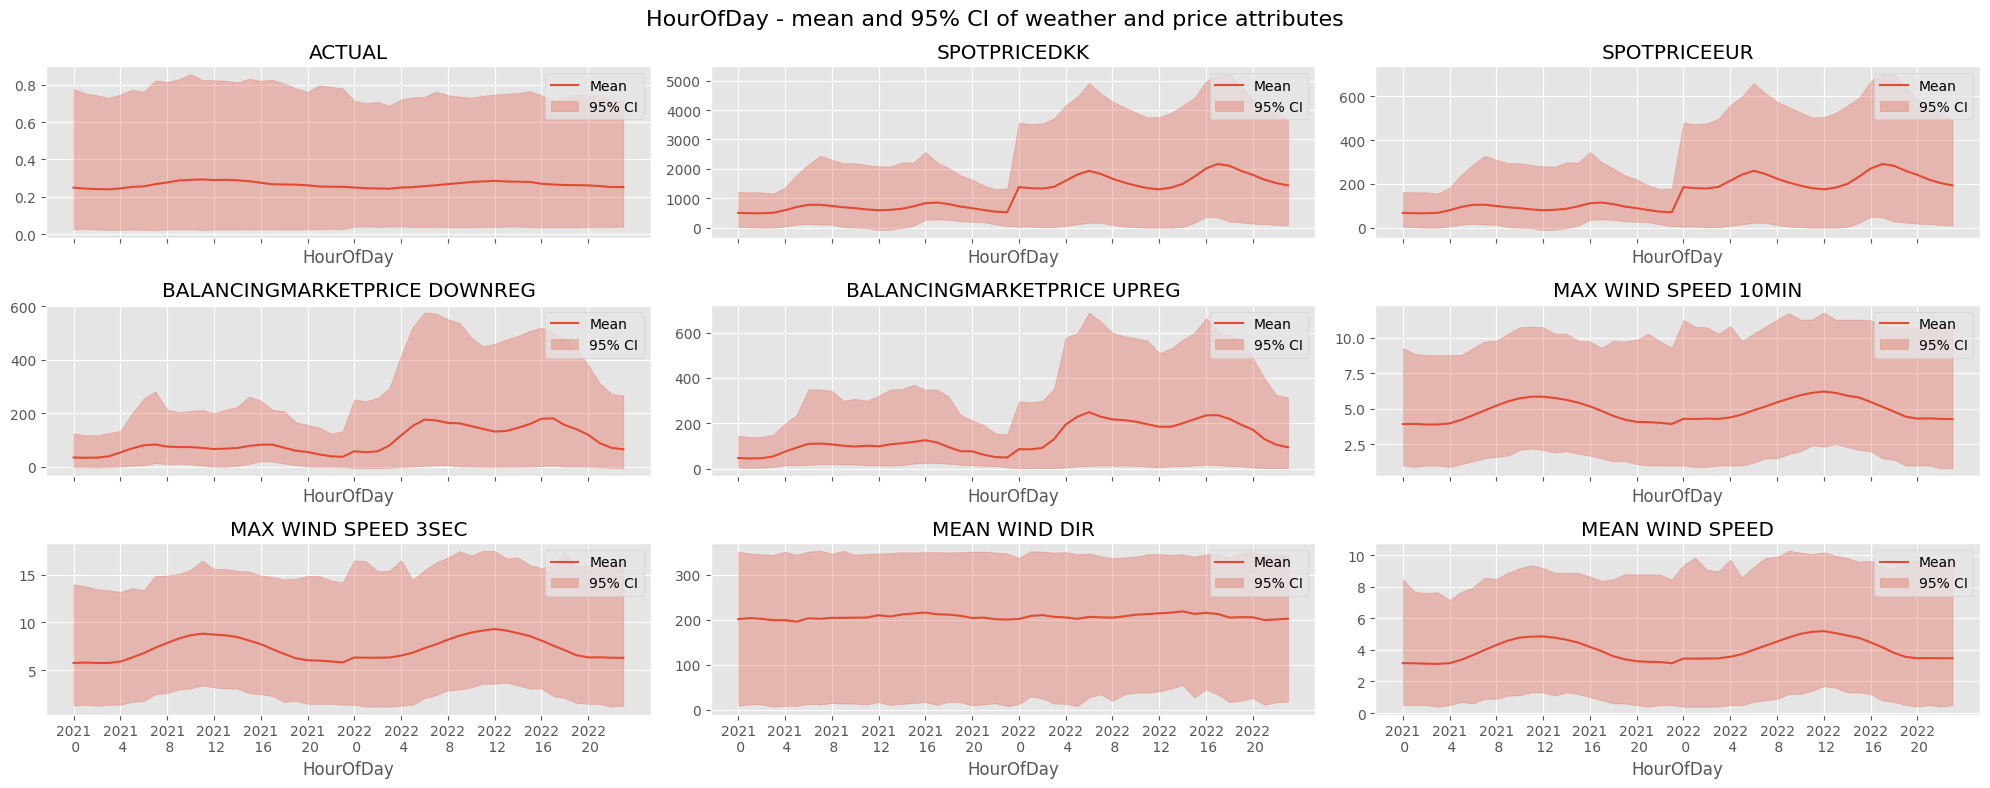

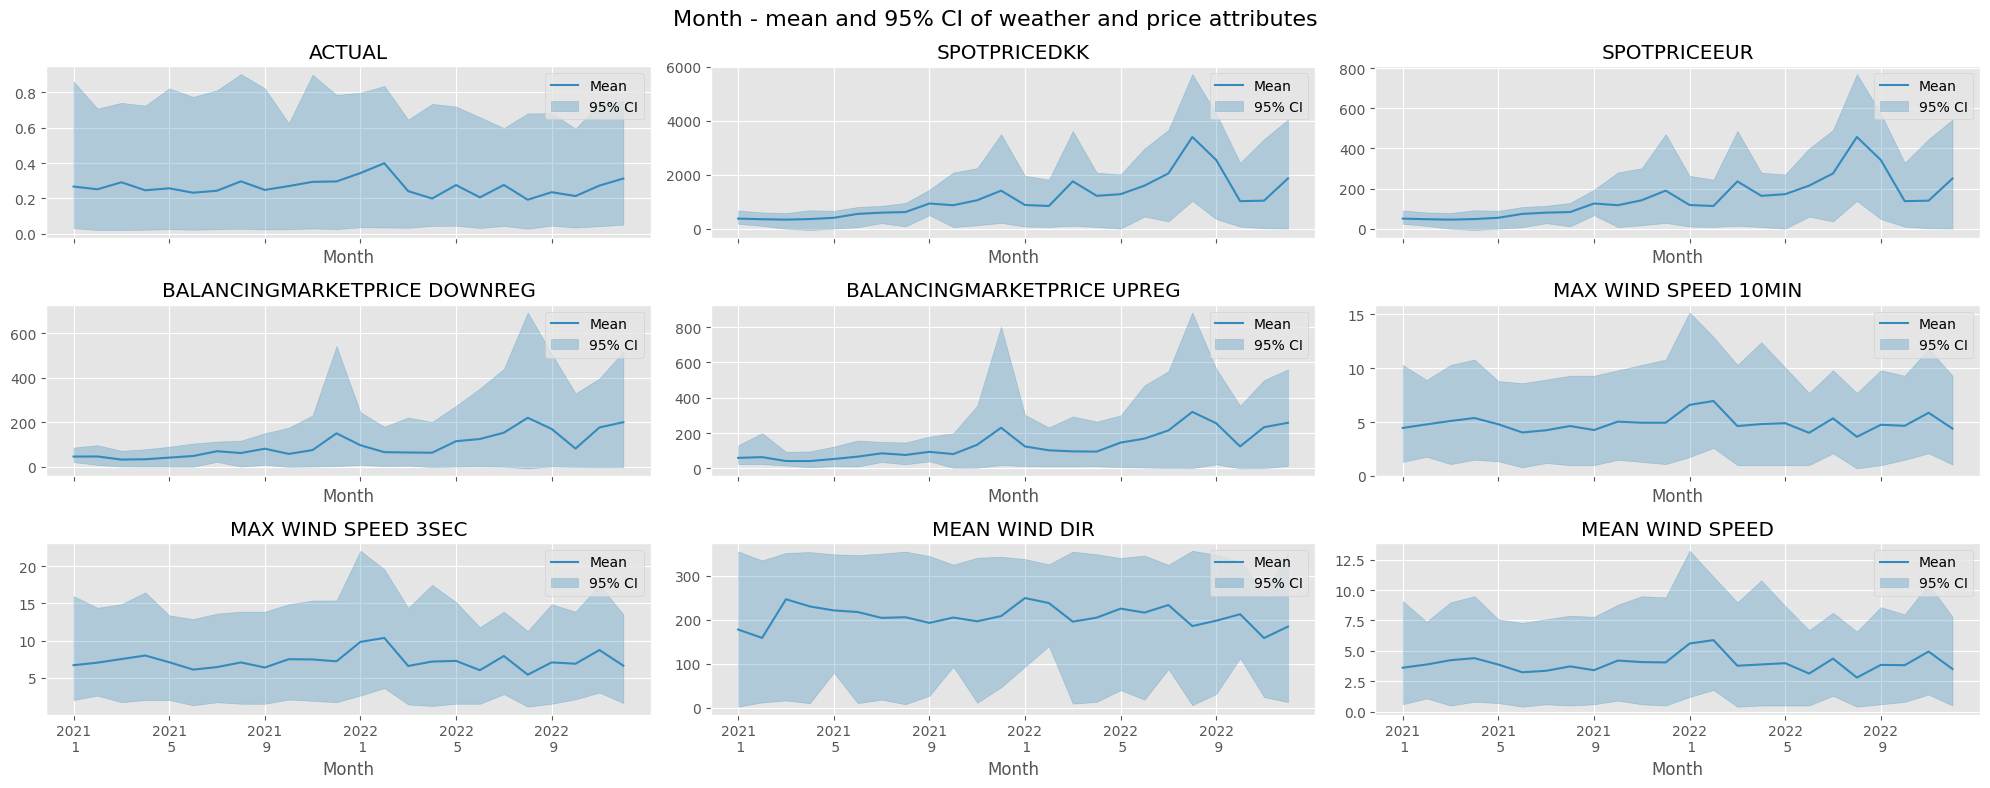

In [32]:
# Add temporal features to the dataset
X               = DK1_dataset.copy()
X['HourOfDay']  = X['StartTimeUTC'].dt.hour
X['Month']      = X['EndTimeUTC'].dt.month
X['Year']       = X['EndTimeUTC'].dt.year

# Choose columns to plot
plot_cols = [
    'Actual', 'SpotPriceDKK', 'SpotPriceEUR', 
    'BalancingMarketPrice_DownReg', 'BalancingMarketPrice_UpReg', 
    'max_wind_speed_10min', 'max_wind_speed_3sec', 'mean_wind_dir', 
    'mean_wind_speed'
]

# Do a visual inspection for temporal trends across years
for j, time_freq in enumerate(['HourOfDay', 'Month']):
    fig, axs = plt.subplots(3, 3, figsize=(20, 8), sharex=True, squeeze=False)

    # Plot all plot_cols
    for i, attr in enumerate(plot_cols):
        # Get mean and 95% CI
        agg_fun                     = [('mean', lambda x: np.mean(x)), ('lowerCI', lambda x: np.percentile(x, q=2.5)), ('upperCI', lambda x: np.percentile(x, q=97.5))]
        # Group by temporal frequency and year
        temp_                       = X.groupby(by=['Year', time_freq])[attr].agg(agg_fun).reset_index()
        temp_[f'Year{time_freq}']   = temp_.apply(lambda x: f"{int(x.Year)}, {int(x[time_freq])}", axis=1)

        # Plot mean and 95% CI
        axs[i // 3, i % 3].plot(temp_[f'Year{time_freq}'], temp_['mean'], color=f'C{j}', label='Mean')
        axs[i // 3, i % 3].fill_between(temp_[f'Year{time_freq}'], temp_['lowerCI'], temp_['upperCI'], color=f'C{j}', alpha=0.3, label='95% CI')

        # Add style to figure
        axs[i // 3, i % 3].set_xticks(np.arange(temp_.__len__())[::4], temp_[f'Year{time_freq}'][::4].apply(lambda x: x.replace(',', '\n')), rotation=0)
        axs[i // 3, i % 3].set_title(attr.replace('_', ' ').upper())
        axs[i // 3, i % 3].set_xlabel(time_freq)
        axs[i // 3, i % 3].legend()

    # Add title
    fig.suptitle(f'{time_freq} - mean and 95% CI of weather and price attributes', fontsize=16)
    plt.tight_layout()
    plt.show()

What the above figures suggest is that there are no clear seasonalities in the actual power production which is the predictive target. There appears to be daily periodic patterns in both of the pricing markets as well as in the observed wind speed for both 2021 and 2022, yet, no obvious periodic trends are seen on a monthly nor yearly level. As is seen on both graphs there is a general increasing trend in the price from 2021 to 2022. 

<a class="anchor" id="optimization"></a>
## 3. Formulating the optimization problem
[_Go to Table of Contents_](#toc-go-back)

<span style="color:red">WRITE THE MATHEMATICS OF THE OPTIMIZATION PROBLEM HERE!</span>

In [8]:
# TODO: GurobiPy implementation here...

<a class="anchor" id="linear-regression"></a>
## 4. Building the linear regression model
[_Go to Table of Contents_](#toc-go-back)

<span style="color:red">DESCRIBE THE DIFFERENT BETWEEN THE TWO APPROACHES IN MATH!</span>


In [37]:
for period in []
np.sin(2*np.pi*DK1_dataset['StartTimeUTC'].dt.hour / 24)
np.cos(2*np.pi*DK1_dataset['StartTimeUTC'].dt.hour / 24)

1         0.000000
8         0.258819
15        0.500000
22        0.707107
29        0.866025
            ...   
122585   -0.965926
122592   -1.000000
122599   -0.965926
122606   -0.866025
122613   -0.707107
Name: StartTimeUTC, Length: 17517, dtype: float64

In [ ]:
def design_matrix(X):
    """
    Create a design matrix from a dataframe X
    """
    X = X.copy()
    

<a class="anchor" id="linear-regression-closed-form"></a>
### 4.1. Closed-form solution

In [ ]:
# TODO: closed-form implentation here...

<a class="anchor" id="linear-regression-gradient-descent"></a>
### 4.2. Gradient descent solution


In [ ]:
# TODO: SGD implementation here...

<a class="anchor" id="regularization-investigation"></a>
## 5. Investigating the role of the regularization parameter
[_Go to Table of Contents_](#toc-go-back)

<span style="color:red">DESCRIBE THE ROLE OF THE REGULARIZATION PARAMETER HERE AND DO THE MATH DERIVATIONS!</span>


In [9]:
# TODO: regularization importance analysis here...